# STEP 1: GET DATA FROM SQL SERVER

1. Connect to SQL Server

In [17]:
import pyodbc

conn = pyodbc.connect('DRIVER={FreeTDS};SERVER=222.252.14.117;PORT=1433;DATABASE=AdventureWorksDW2019;UID=hocvienda;PWD=dahkpim;TDS_Version=8.0')
cursor = conn.cursor()

2. Query SQL Server Data

In [5]:
import pandas as pd

# Get data with SQL Query
trend_data = pd.read_sql_query('''
SELECT [OrderDate] as date, SUM([SalesAmount]) as sales
FROM dbo.[FactInternetSales]
WhERE OrderDate >= '2011-01-01' and OrderDate <= '2013-12-28'
WhERE OrderDate >= '2011-01-01' and OrderDate <= '2013-12-28'
GROUP BY [OrderDate]
ORDER BY [OrderDate]
''', conn)
# Create data frame
df = pd.DataFrame(trend_data)
# Add month column
#df['month'] = df['date'].dt.month
#Read data
df.head(5)

,date,sales
0,2011-01-01,7156.54
1,2011-01-02,15012.18
2,2011-01-03,14313.08
3,2011-01-04,7855.64
4,2011-01-05,7855.64


3. Plot the data

Text(0, 0.5, 'Sales ($)')

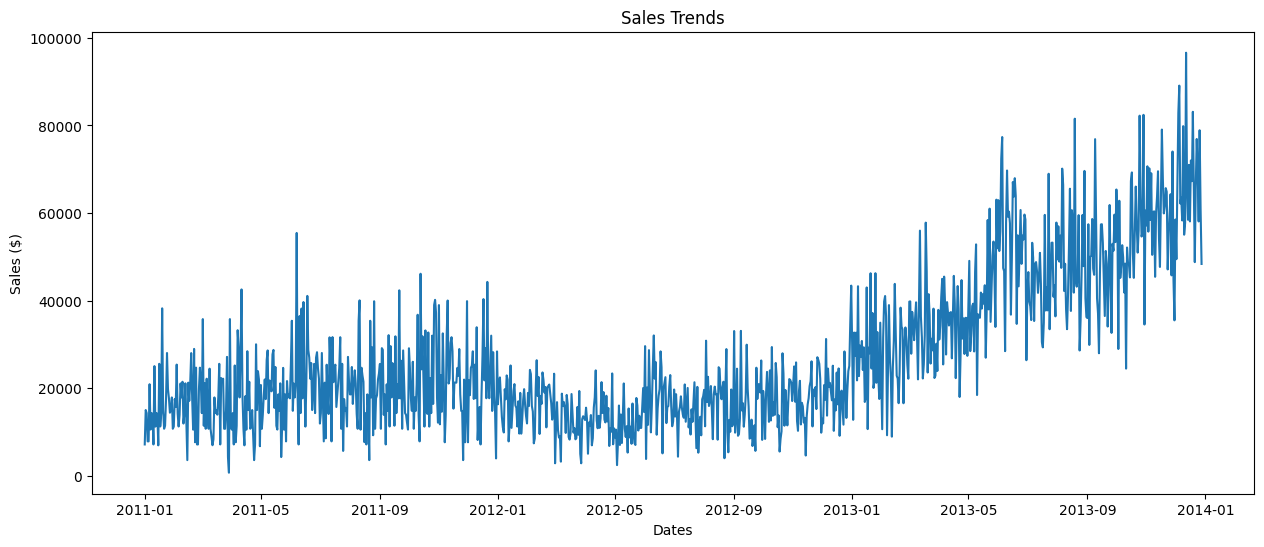

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=df['date'], y=df['sales'])
ax.set_title('Sales Trends')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')

# STEP 2: DECOMPISION OF TIME SERIES DATA

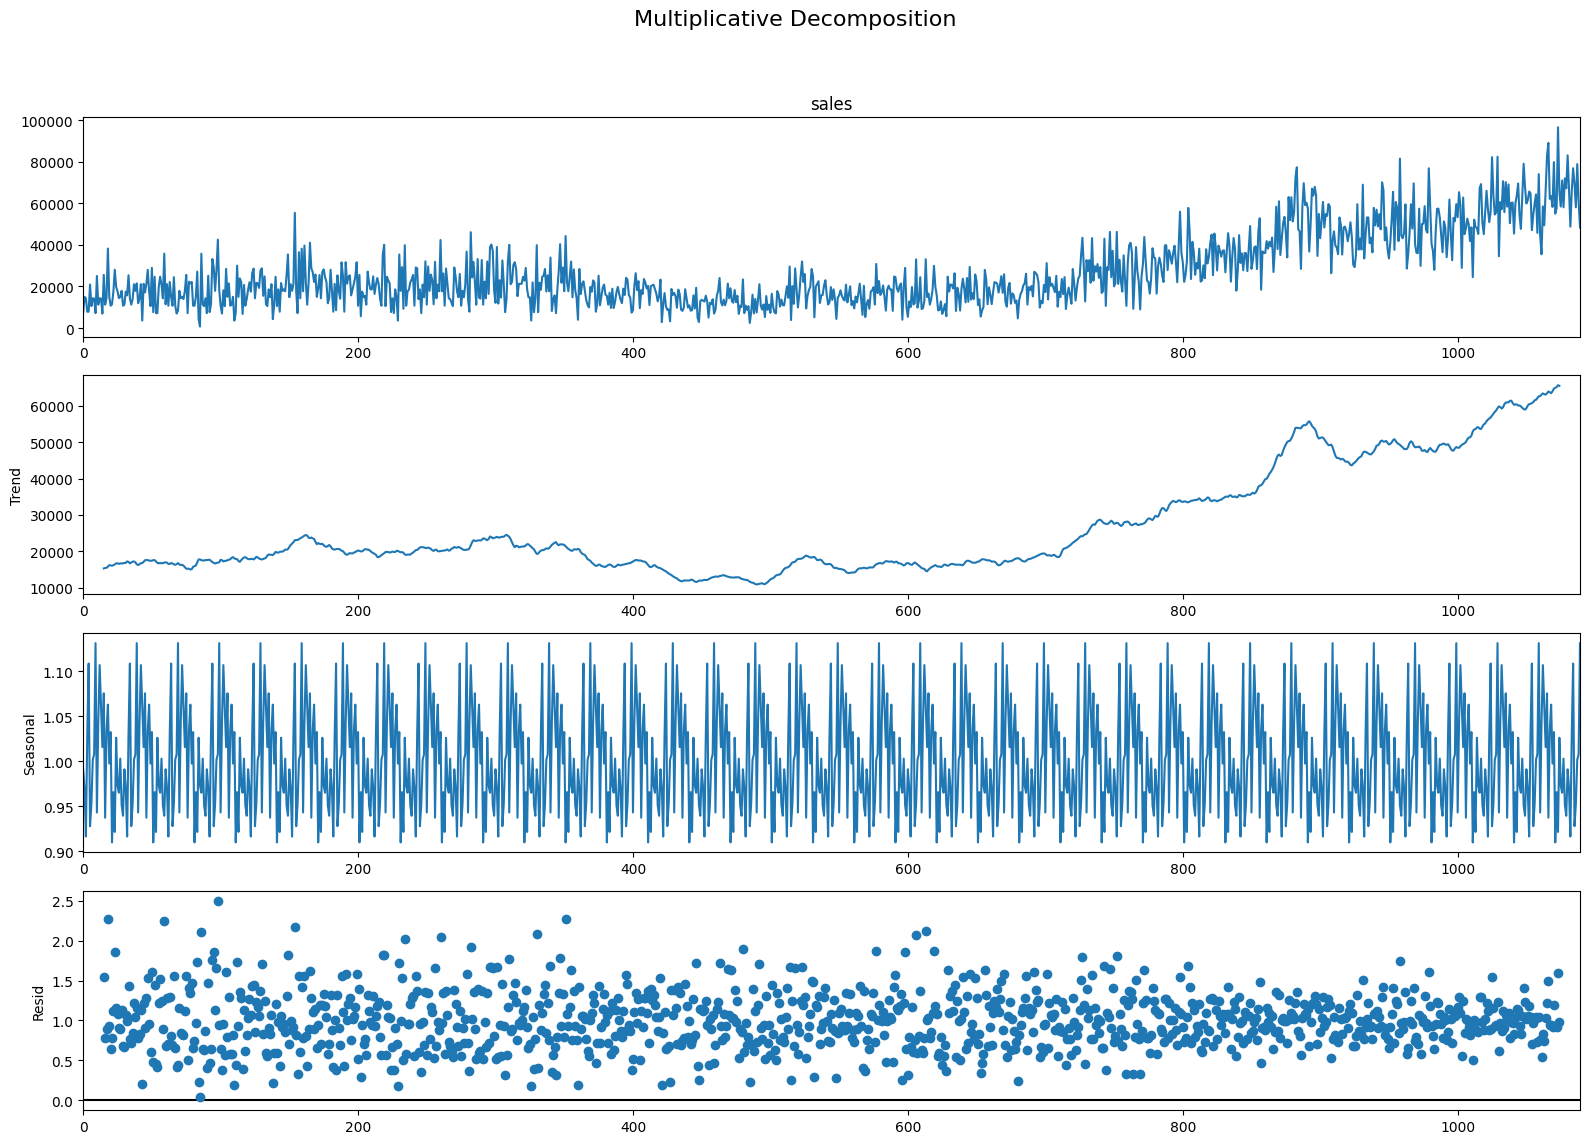

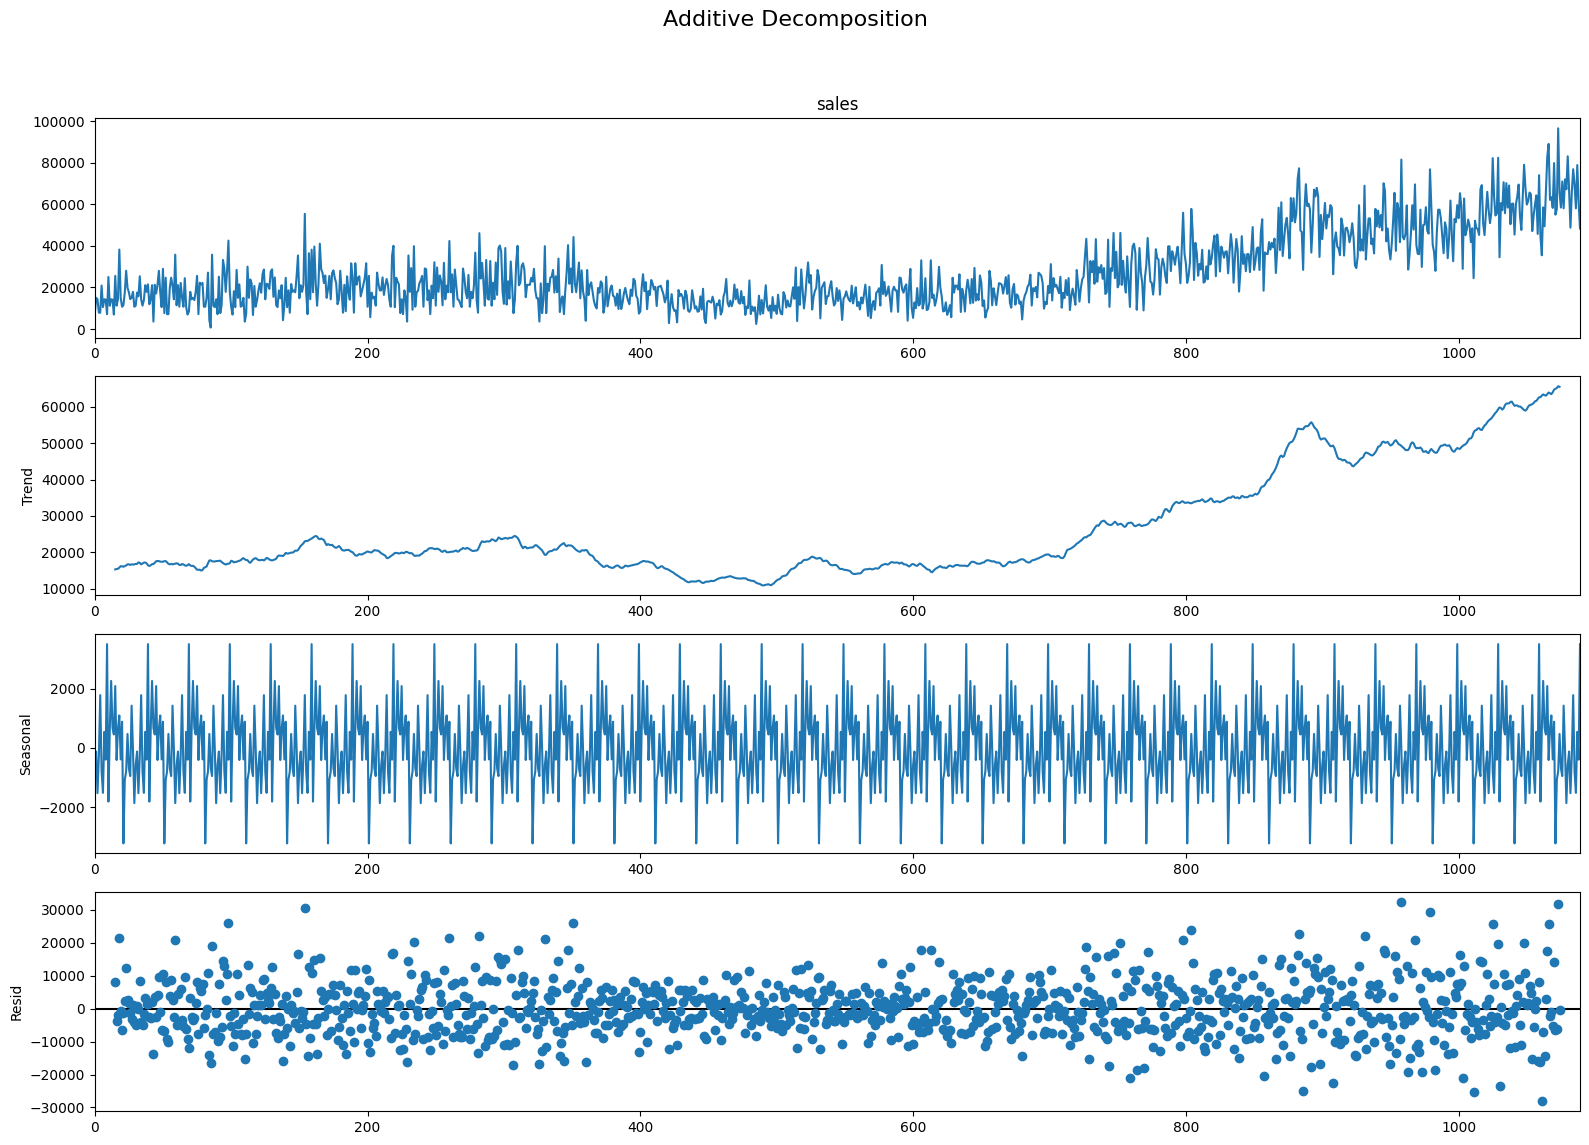

In [7]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['sales'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(df['sales'], model='additive', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# STEP 3: STATIONARITY TEST WITH ADF

In [8]:
def check_stationarity(df): # df: array_like, 1d
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print('ADF Statistic: %f' % adf)
    print('p-value: %f' % pvalue)
    if (pvalue < 0.05) and (adf < critical_value): print('The series is stationary')
    else: print('The series is NOT stationary')

check_stationarity(df['sales'])

ADF Statistic: -0.270547
p-value: 0.929573
The series is NOT stationary


# STEP 4: SEASONALITY TEST WITH ACF

1. Run Auto Correlation Function (ACF)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

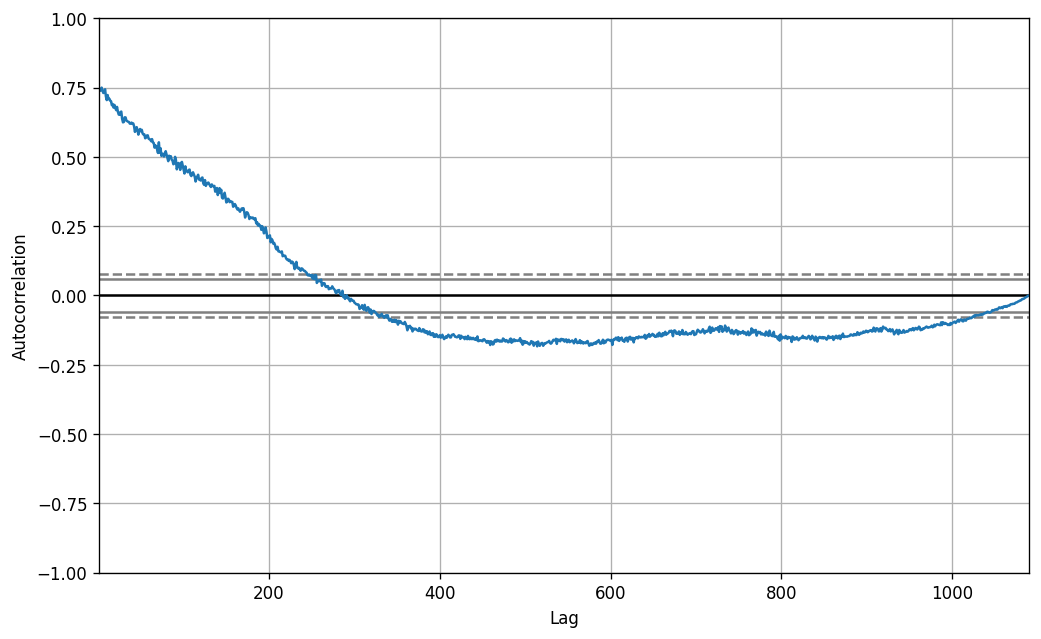

In [9]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

2. Run Lag Plot

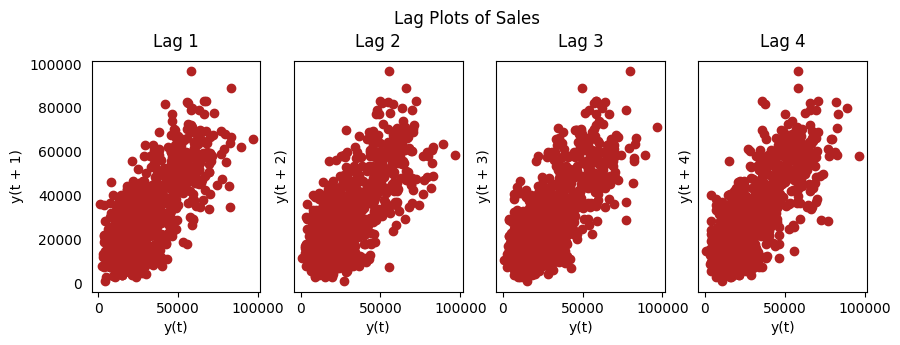

In [10]:
from pandas.plotting import lag_plot

plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title(f'Lag {str(i + 1)}')
fig.suptitle('Lag Plots of Sales', y=1.05)
plt.show()

# STEP 5: SPLIT TRAIN & TEST DATA

In [11]:
print('Dataset: %d' % len(df))
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train_df, test_df = df[:train_size], df[train_size:]
test_df.index = test_df.index - train_size
print("Train Size:", train_size)
print(train_df)
print(test_df)

Dataset: 1090
Train Size: 872
          date    sales
0   2011-01-01  7156.54
1   2011-01-02 15012.18
2   2011-01-03 14313.08
3   2011-01-04  7855.64
4   2011-01-05  7855.64
..         ...      ...
867 2013-05-20 38025.50
868 2013-05-21 58402.96
869 2013-05-22 38000.76
870 2013-05-23 61004.75
871 2013-05-24 35148.85

[872 rows x 2 columns]
          date    sales
0   2013-05-25 42799.34
1   2013-05-26 50332.82
2   2013-05-27 53495.71
3   2013-05-28 45631.11
4   2013-05-29 33988.45
..         ...      ...
213 2013-12-24 69533.64
214 2013-12-25 58080.78
215 2013-12-26 78906.59
216 2013-12-27 60959.78
217 2013-12-28 48375.33

[218 rows x 2 columns]


# STEP 6: ARIMA MODEL TRAINING & PREDICTION

1. ARIMA Model Training

predicted=45037.035515, expected=42799.340000
predicted=46552.630919, expected=50332.820000
predicted=42417.750634, expected=53495.710000
predicted=48671.311298, expected=45631.110000
predicted=49969.331019, expected=33988.450000
predicted=44787.814701, expected=63052.590000
predicted=46970.969189, expected=51951.600000
predicted=49389.706429, expected=62935.460000
predicted=59201.090218, expected=51323.580000
predicted=55545.861308, expected=55816.680000
predicted=56747.781577, expected=72376.460000
predicted=59318.126543, expected=77359.340000
predicted=68173.413479, expected=47438.010000
predicted=66410.673661, expected=46708.250000
predicted=57673.493096, expected=28462.060000
predicted=41122.747205, expected=57790.020000
predicted=43945.283496, expected=69712.490000
predicted=51602.766332, expected=59151.700000
predicted=62246.329674, expected=60327.800000
predicted=63112.133776, expected=57660.180000
predicted=59063.127071, expected=36793.070000
predicted=51769.152076, expected=4

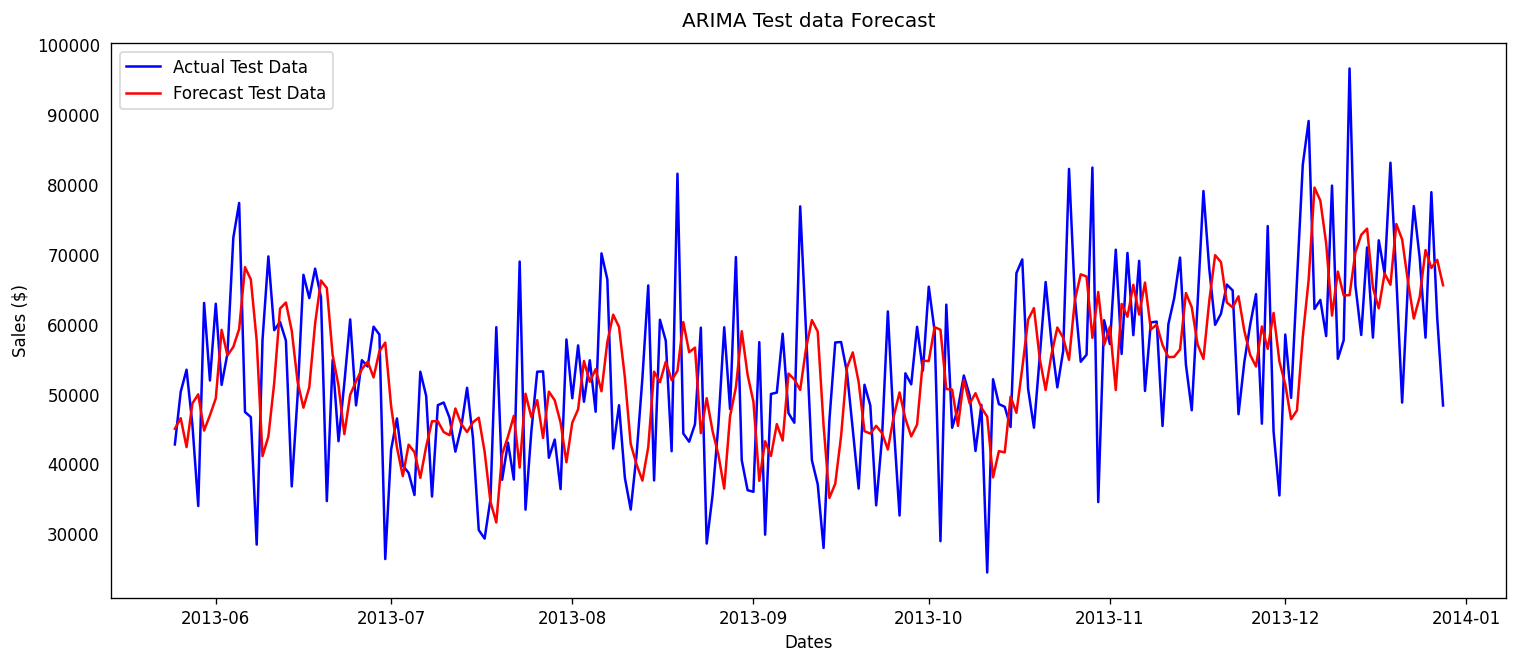

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

history = list(train_df['sales'])
prediction_df = test_df.copy()

# walk-forward validation
for t in range(len(test_df)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    prediction_df['sales'][t] = yhat
    obs = test_df['sales'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test_df['sales'], prediction_df['sales']))
print(test_df)
print(prediction_df)
print('Test RMSE: %.3f' % rmse)
print(f'mean = {test_df.mean()}')
print(rmse/test_df.mean() * 100, '%')

fig, ax = plt.subplots(figsize=(15,6))
actual_line = sns.lineplot(x=test_df['date'], y=test_df['sales'], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=prediction_df['date'], y=prediction_df['sales'], label='Forecast Test Data', color='red')

actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Test data Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')
plt.show()

2. ARIMA Model Prediction

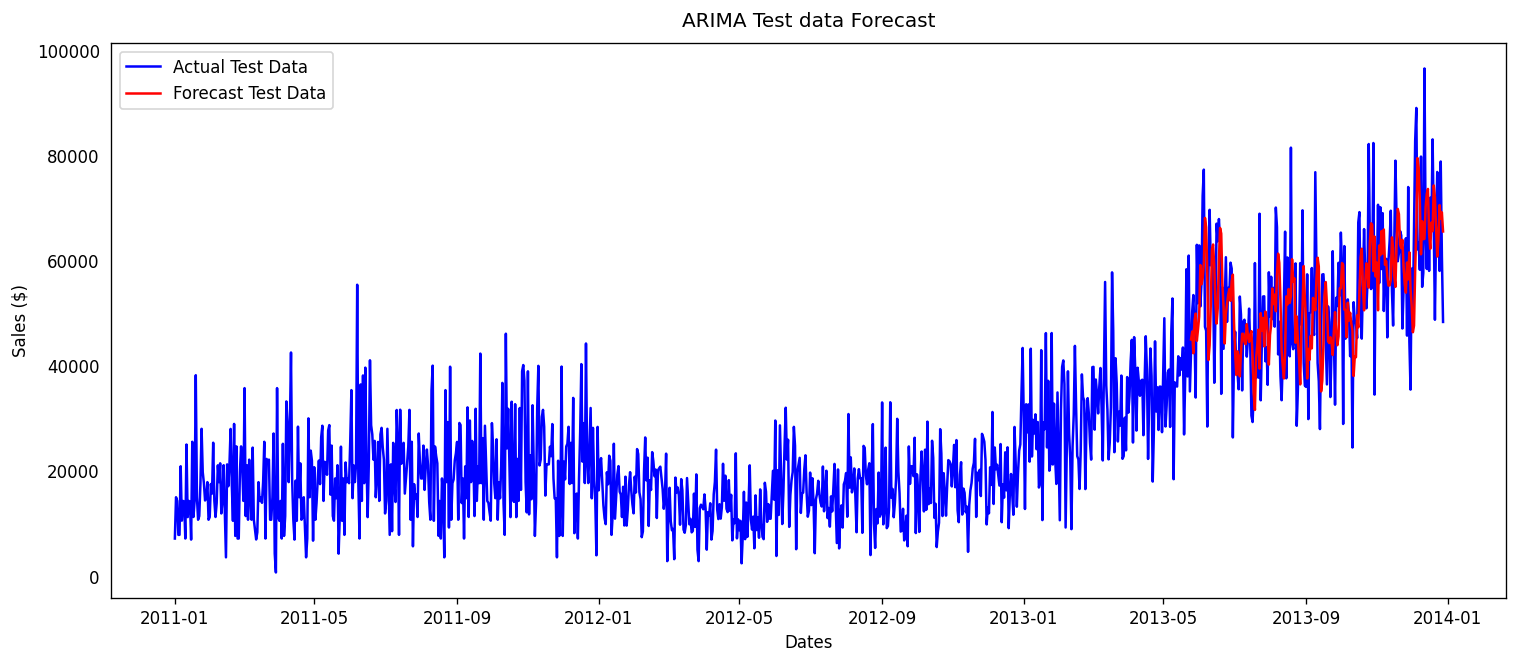

In [13]:
prediction_df.index = prediction_df.index + train_size
# print(prediction_df)
fig, ax = plt.subplots(figsize=(15,6))
actual_line = sns.lineplot(x=df['date'], y=df['sales'], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=prediction_df['date'], y=prediction_df['sales'], label='Forecast Test Data', color='red')

actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Test data Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')
plt.show()

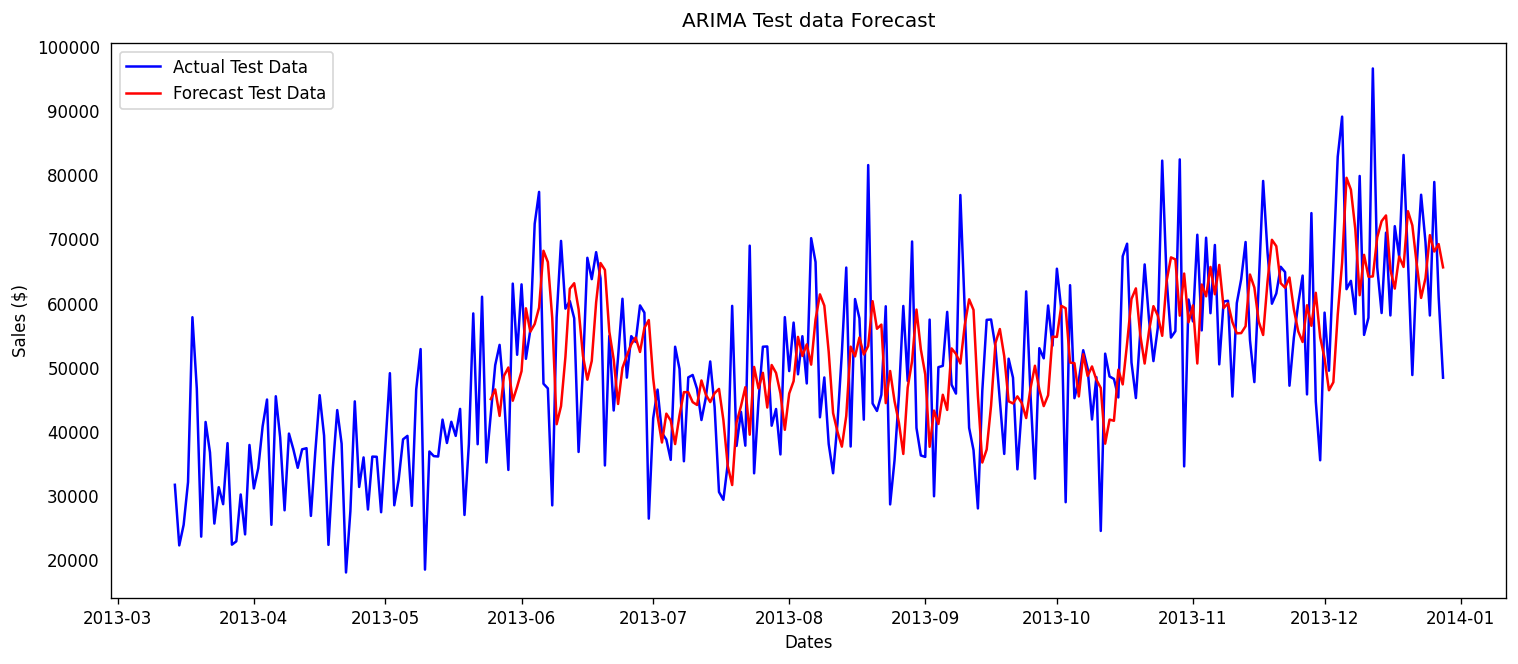

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
actual_line = sns.lineplot(x=df[800:]['date'], y=df['sales'][800:], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=prediction_df['date'], y=prediction_df['sales'], label='Forecast Test Data', color='red')

actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Test data Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')
plt.show()

Text(0, 0.5, 'Sales ($)')

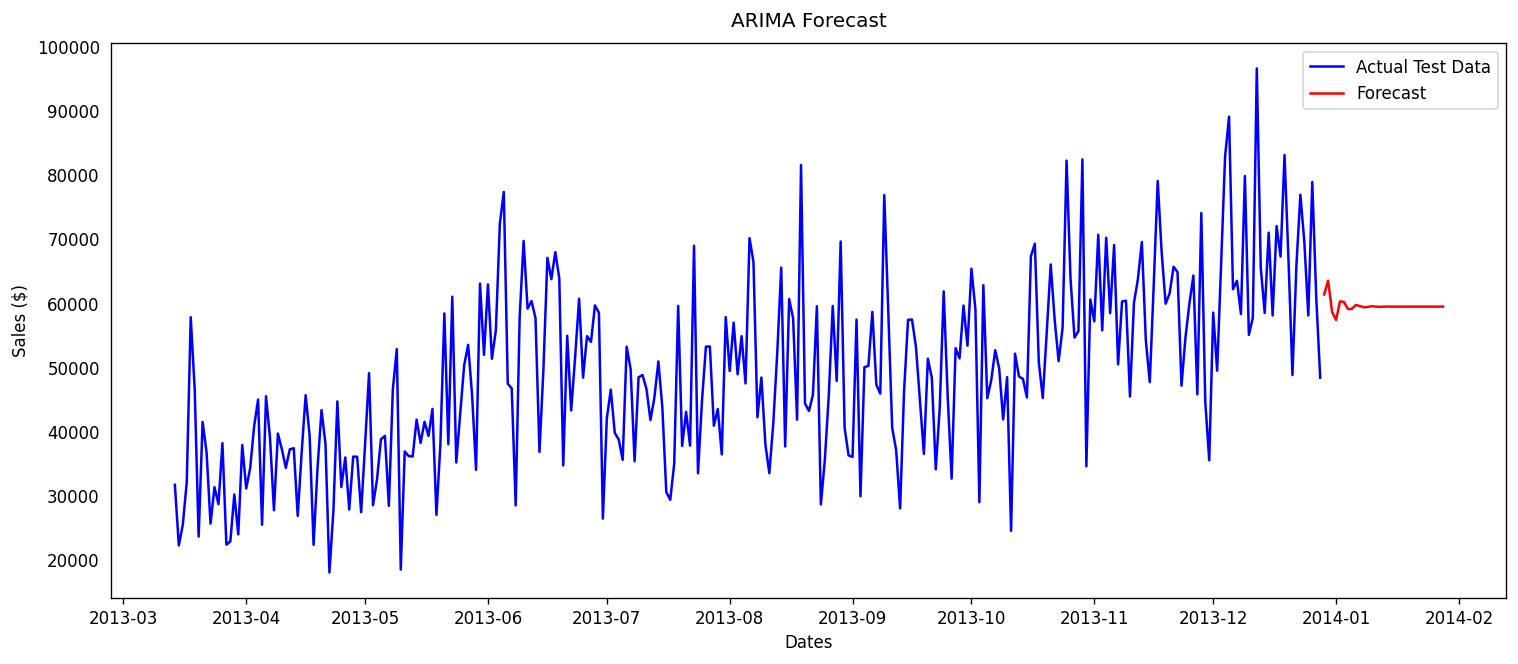

In [15]:
future_df = pd.DataFrame(pd.date_range(start='2013-12-29', periods = 31),columns=['date'])
# for t in range(len(future_df)):
# output = model_fit.forecast()
# future_forecasts.append(output[0])
# future_forecasts = model_fit.forecast(steps=len(future_df))
# future_df['sales'] = future_forecasts
# print(future_df)
history = list(df['sales'])
future_forecasts = []

# walk-forward validation
for _ in range(len(future_df)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    future_forecasts.append(yhat)
    history.append(yhat)
future_df['sales'] = future_forecasts
fig, ax = plt.subplots(figsize=(15,6))

actual_line = sns.lineplot(x=df[800:]['date'], y=df['sales'][800:], label='Actual Test Data', color='blue')
predict_line = sns.lineplot(x=future_df['date'], y=future_df['sales'], label='Forecast', color ='red')
actual_line.legend()
predict_line.legend()
ax.set_title('ARIMA Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Sales ($)')